<a href="https://colab.research.google.com/github/Ptuancuong/TH-TimeSeries.csv/blob/main/ThucHanh04.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
a = 2251262584%8+1
a

1

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

file_path = "/content/household_power_consumption.csv"
df = pd.read_csv(file_path, sep=',', low_memory=False)
df.head()


,index,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,0,1/1/07,0:00:00,2.58,0.136,241.97,10.6,0,0,0.0
1,1,1/1/07,0:01:00,2.552,0.1,241.75,10.4,0,0,0.0
2,2,1/1/07,0:02:00,2.55,0.1,241.64,10.4,0,0,0.0
3,3,1/1/07,0:03:00,2.55,0.1,241.71,10.4,0,0,0.0
4,4,1/1/07,0:04:00,2.554,0.1,241.98,10.4,0,0,0.0


In [3]:
# Đọc lại dữ liệu với phân tách dấu phẩy
df = pd.read_csv(file_path, sep=',', low_memory=False)

df['datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], format='%d/%m/%y %H:%M:%S', errors='coerce')

# Chuyển cột Global_active_power sang dạng số và xử lý dữ liệu thiếu
df['Global_active_power'] = pd.to_numeric(df['Global_active_power'], errors='coerce')
df = df[['datetime', 'Global_active_power']].dropna()

# Đặt datetime làm index và resample theo giờ (lấy trung bình mỗi giờ)
df.set_index('datetime', inplace=True)
df_hourly = df.resample('H').mean().interpolate()

df_hourly.head()


<ipython-input-3-7d6ae88e3955>:12: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_hourly = df.resample('H').mean().interpolate()


,Global_active_power
datetime,
2007-01-01 00:00:00,2.550633
2007-01-01 01:00:00,2.523400
2007-01-01 02:00:00,2.582333
2007-01-01 03:00:00,2.541667
2007-01-01 04:00:00,2.475733


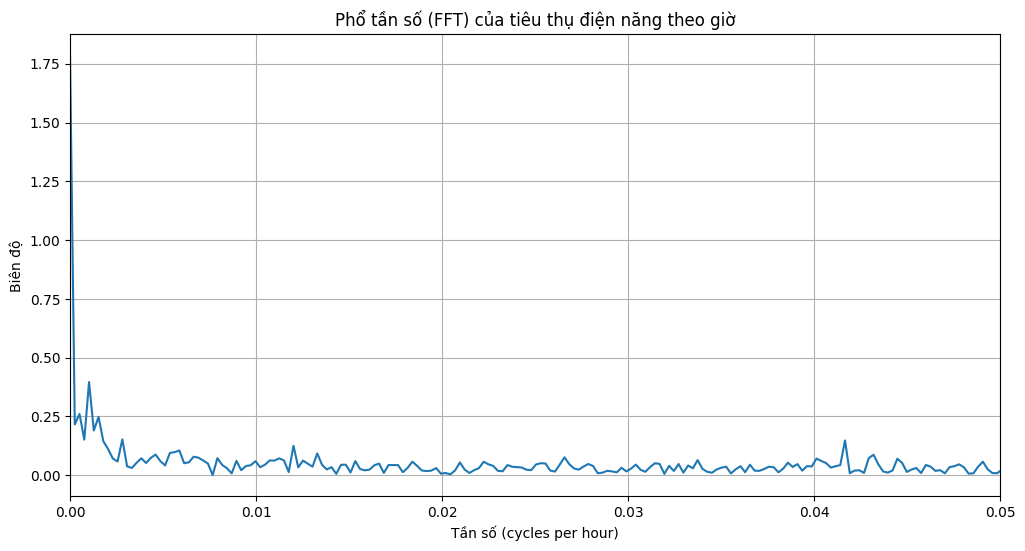

In [4]:
from numpy.fft import fft, fftfreq

# Lấy chuỗi thời gian tiêu thụ điện năng
y = df_hourly['Global_active_power'].values
n = len(y)
timestep = 1  # mỗi bước là 1 giờ

yf = fft(y)
xf = fftfreq(n, d=timestep)

# Chỉ lấy phần phổ dương
xf_pos = xf[:n // 2]
yf_pos = 2.0 / n * np.abs(yf[:n // 2])

# Trực quan hóa phổ tần số
plt.figure(figsize=(12, 6))
plt.plot(xf_pos, yf_pos)
plt.title('Phổ tần số (FFT) của tiêu thụ điện năng theo giờ')
plt.xlabel('Tần số (cycles per hour)')
plt.ylabel('Biên độ')
plt.grid(True)
plt.xlim(0, 0.05)  # chỉ hiển thị tần số thấp để thấy chu kỳ dài hơn
plt.show()


In [5]:
# Tìm tần số chiếm ưu thế (đỉnh lớn nhất trong phổ)
dominant_idx = np.argmax(yf_pos)
dominant_freq = xf_pos[dominant_idx]
dominant_period_hours = 1 / dominant_freq

dominant_freq, dominant_period_hours


<ipython-input-5-31d33cf746eb>:4: RuntimeWarning: divide by zero encountered in scalar divide
  dominant_period_hours = 1 / dominant_freq


(np.float64(0.0), np.float64(inf))

In [6]:
# Bỏ qua phần tử đầu tiên (tần số 0 Hz)
dominant_idx = np.argmax(yf_pos[1:]) + 1
dominant_freq = xf_pos[dominant_idx]
dominant_period_hours = 1 / dominant_freq

dominant_freq, dominant_period_hours


(np.float64(0.0010224948875255625), np.float64(977.9999999999999))

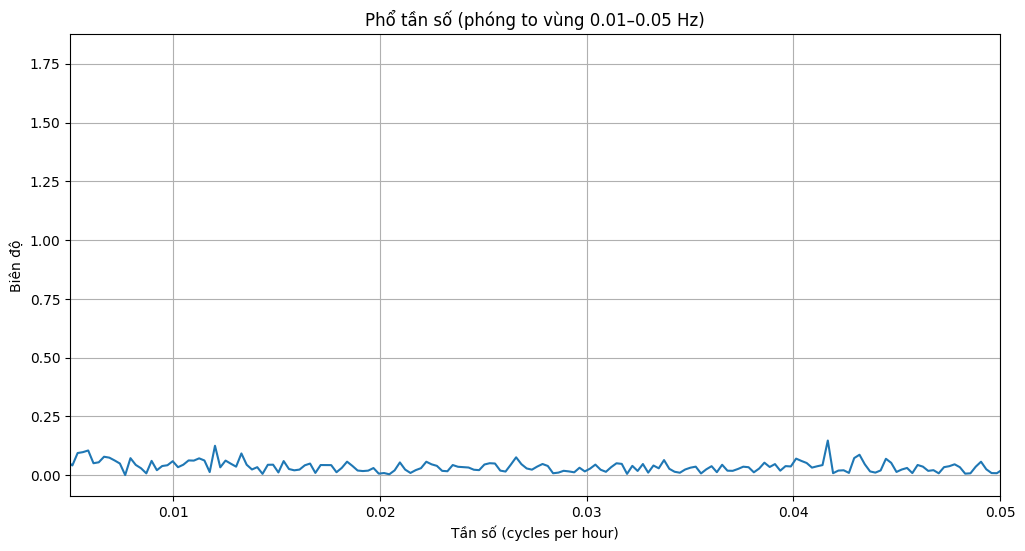

In [7]:
# Vẽ lại phổ tần số trong vùng nghi ngờ có chu kỳ ngày và tuần
plt.figure(figsize=(12, 6))
plt.plot(xf_pos, yf_pos)
plt.title('Phổ tần số (phóng to vùng 0.01–0.05 Hz)')
plt.xlabel('Tần số (cycles per hour)')
plt.ylabel('Biên độ')
plt.grid(True)
plt.xlim(0.005, 0.05)  # vùng chứa các chu kỳ từ ~20h đến ~200h
plt.show()


In [9]:
# Tổng hợp dữ liệu theo giờ
df_hourly = df.resample('H').mean().interpolate()

# Phân tích mức tiêu thụ trung bình theo từng giờ trong ngày
df_hourly['hour'] = df_hourly.index.hour
avg_by_hour = df_hourly.groupby('hour')['Global_active_power'].mean()

# Hiển thị giá trị trung bình theo giờ (in bảng nếu cần)
print("Mức tiêu thụ trung bình theo từng giờ (kWh):")
print(avg_by_hour)

Mức tiêu thụ trung bình theo từng giờ (kWh):
hour
0     0.757507
1     0.673865
2     0.623383
3     0.623069
4     0.609174
5     0.638078
6     0.787893
7     1.010105
8     1.012605
9     0.979241
10    0.925211
11    0.897930
12    0.834164
13    0.835138
14    0.856935
15    0.830149
16    0.812044
17    0.854741
18    1.055444
19    1.316782
20    1.246259
21    1.299634
22    1.111838
23    0.841971
Name: Global_active_power, dtype: float64


<ipython-input-9-9beec83d5b35>:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_hourly = df.resample('H').mean().interpolate()


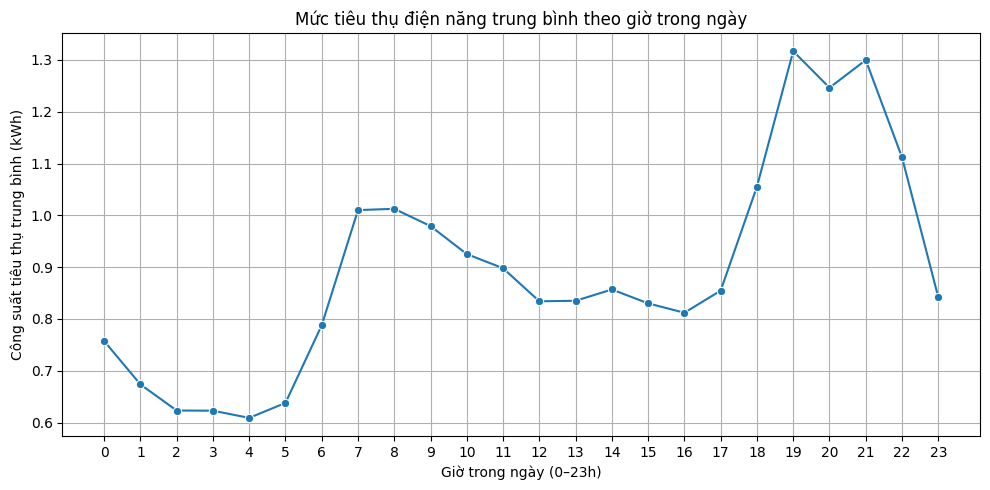

In [14]:
import seaborn as sns
plt.figure(figsize=(10, 5))
sns.lineplot(x=avg_by_hour.index, y=avg_by_hour.values, marker='o')
plt.title('Mức tiêu thụ điện năng trung bình theo giờ trong ngày')
plt.xlabel('Giờ trong ngày (0–23h)')
plt.ylabel('Công suất tiêu thụ trung bình (kWh)')
plt.grid(True)
plt.xticks(range(0, 24))
plt.tight_layout()
plt.show()